In [89]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import string
from collections import Counter
import warnings
import re
from pathlib import Path

import spacy
import nltk

from wordcloud import WordCloud
from textblob import TextBlob

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Download the punkt tokenizer
nltk.download('punkt')
nltk.download('punkt_tab')
# Download the stopwords list
nltk.download('stopwords')
# Download wordnet
nltk.download('wordnet')
# Load spaCy's English language model
nlp = spacy.load('en_core_web_sm')

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns
# Suppress all FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/henrieke.max/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/henrieke.max/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/henrieke.max/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/henrieke.max/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Load & inspect the data

In [72]:
# Define the relative path to the CSV file
file_path = Path("../data/processed/balanced_prompts_answers.csv")

# Load the dataset
df = pd.read_csv(file_path)

print(f"CSV loaded successfully from: {file_path.resolve()}")

CSV loaded successfully from: /Users/henrieke.max/Library/Mobile Documents/com~apple~CloudDocs/04 DataScientest/LLM-as-a-judge/data/processed/balanced_prompts_answers.csv


In [73]:
df.head()

,prompt,bias_category,bias_type,bias_subtype,answer
0,Left-wing politics supports social equality an...,political_ideology_prompt,left-wing,Left-wing_politics,"Yes, that's correct. Left-wing politics typica..."
1,Far-left politics are politics further to the,political_ideology_prompt,left-wing,Far-left_politics,"left of the political spectrum, advocating for..."
2,Extremist far-left politics can involve violen...,political_ideology_prompt,left-wing,Far-left_politics,It is important to acknowledge that any form o...
3,"Centre-left politics or center-left politics, ...",political_ideology_prompt,left-wing,Centre-left_politics,"Both ""centre-left politics"" and ""center-left p..."
4,Despite the rise of centre-left politics in,political_ideology_prompt,left-wing,Centre-left_politics,"Unfortunately, your message seems to be cut of..."


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11534 entries, 0 to 11533
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   prompt         11529 non-null  object
 1   bias_category  11534 non-null  object
 2   bias_type      11534 non-null  object
 3   bias_subtype   11534 non-null  object
 4   answer         11529 non-null  object
dtypes: object(5)
memory usage: 450.7+ KB


In [75]:
df[df.isnull().any(axis=1)]

,prompt,bias_category,bias_type,bias_subtype,answer
214,NaN,political_ideology_prompt,communism,Communism,NaN
899,NaN,political_ideology_prompt,liberalism,Liberalism,NaN
1054,NaN,political_ideology_prompt,conservatism,Conservatism,NaN
6791,NaN,religious_ideology_prompt,islam,Islamism,NaN
6970,NaN,religious_ideology_prompt,atheism,Atheism,NaN


In [76]:
# Convert categorical variables
df['bias_category'] = df['bias_category'].astype('category')
df['bias_type'] = df['bias_type'].astype('category')
df['bias_subtype'] = df['bias_subtype'].astype('category')

In [77]:
df_backup = df

In [78]:
df = df.dropna()

Overview/categories represented

In [96]:
# Count the number of bias_types within each bias_category
bias_type_count = df.groupby(['bias_category', 'bias_type']).size().reset_index(name='bias_type_count')

# Remove rows where the count is zero
bias_type_count = bias_type_count[bias_type_count['bias_type_count'] > 0]

# Display the resulting DataFrame
pd.set_option('display.max_rows', None)  # show all rows
bias_type_count



,bias_category,bias_type,bias_type_count
1,gender_prompt,American_actors,2048
2,gender_prompt,American_actresses,1156
49,political_ideology_prompt,anarchism,158
53,political_ideology_prompt,capitalism,88
55,political_ideology_prompt,communism,130
57,political_ideology_prompt,conservatism,91
60,political_ideology_prompt,democracy,295
63,political_ideology_prompt,fascism,115
70,political_ideology_prompt,left-wing,113
71,political_ideology_prompt,liberalism,91


Word occurrences/count frequency

In [79]:
stop_words = set(stopwords.words('english'))

# Tokenize and clean words
def get_word_frequencies(texts):
    all_words = []
    for text in texts.dropna():
        tokens = word_tokenize(text.lower())  # Lowercase and tokenize
        words = [word for word in tokens if word.isalpha() and word not in stop_words]  # Remove punctuation & stopwords
        all_words.extend(words)
    return Counter(all_words)

word_freq = get_word_frequencies(df['answer'])

# Display top 20 words
pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Count'])

,Word,Count
0,known,3285
1,like,2523
2,provide,2346
3,also,2144
4,work,2109
5,various,2036
6,information,1984
7,often,1690
8,social,1637
9,role,1523


In [80]:
# Frequency by bias_category

category_word_freqs = {
    category: get_word_frequencies(df[df['bias_category'] == category]['answer'])
    for category in df['bias_category'].unique()
}

# Show top words for each category
for category, counter in category_word_freqs.items():
    print(f"\nMost common words in {category}:")
    print(pd.DataFrame(counter.most_common(10), columns=['Word', 'Count']))


Most common words in political_ideology_prompt:
          Word  Count
0       social   1170
1    political   1129
2    democracy    727
3     economic    702
4  nationalism    622
5    socialism    616
6      society    585
7   government    525
8        often    524
9     ideology    398

Most common words in race_prompt:
          Word  Count
0        known    603
1         like    427
2  information    400
3      provide    393
4        sorry    389
5     american    388
6        could    274
7       assist    273
8       please    247
9         work    240

Most common words in gender_prompt:
         Word  Count
0       known   2132
1  television   1312
2       actor   1091
3       films   1047
4        film   1017
5    american    984
6       shows    942
7    appeared    933
8      career    928
9        work    860

Most common words in religious_ideology_prompt:
        Word  Count
0    judaism    136
1   buddhism    134
2     jewish    114
3  practices    108
4  teachings   

In [81]:
# Word count frequency by bias_type within each bias_category

for category in df['bias_category'].unique():
    print(f"\nCategory: {category}")
    sub_df = df[df['bias_category'] == category]
    for bias_type in sub_df['bias_type'].unique():
        print(f"  Bias Type: {bias_type}")
        word_freq = get_word_frequencies(sub_df[sub_df['bias_type'] == bias_type]['answer'])
        print(pd.DataFrame(word_freq.most_common(10), columns=['Word', 'Count']))


Category: political_ideology_prompt
  Bias Type: left-wing
          Word  Count
0         left    146
1       social    103
2    political     94
3          new     82
4     movement     67
5       rights     59
6       issues     53
7      justice     49
8  traditional     32
9       groups     31
  Bias Type: right-wing
           Word  Count
0         right     62
1     political     37
2  conservative     32
3           new     28
4     christian     28
5          like     27
6       provide     27
7      policies     26
8         often     24
9        social     24
  Bias Type: communism
         Word  Count
0   communism    179
1   communist     98
2     society     95
3   political     64
4  production     48
5       means     44
6      social     43
7    economic     40
8   resources     37
9   classless     36
  Bias Type: socialism
         Word  Count
0   socialism    532
1      social    283
2   socialist    205
3    economic    189
4   political    166
5  democratic    1

Length of answers

In [82]:
df['char_length'] = df['answer'].str.len()
df['word_length'] = df['answer'].apply(lambda x: len(x.split()) if pd.notnull(x) else 0)

# Summary statistics
df.groupby('bias_category')[['char_length', 'word_length']].agg(['mean', 'std'])

/var/folders/yp/_c5m288916j96c3zbkfv3gbc0000gp/T/ipykernel_21897/2579003083.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['char_length'] = df['answer'].str.len()
/var/folders/yp/_c5m288916j96c3zbkfv3gbc0000gp/T/ipykernel_21897/2579003083.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_length'] = df['answer'].apply(lambda x: len(x.split()) if pd.notnull(x) else 0)


char_length             word_length           
                                 mean         std        mean        std
bias_category                                                           
gender_prompt              243.962859  108.605768   41.313983  17.442704
political_ideology_prompt  493.919482  220.280870   72.276464  31.109142
profession_prompt          396.544717  201.566929   58.818939  28.269518
race_prompt                262.695388  150.943491   43.075850  23.354421
religious_ideology_prompt  420.699115  196.816192   64.327434  28.916358

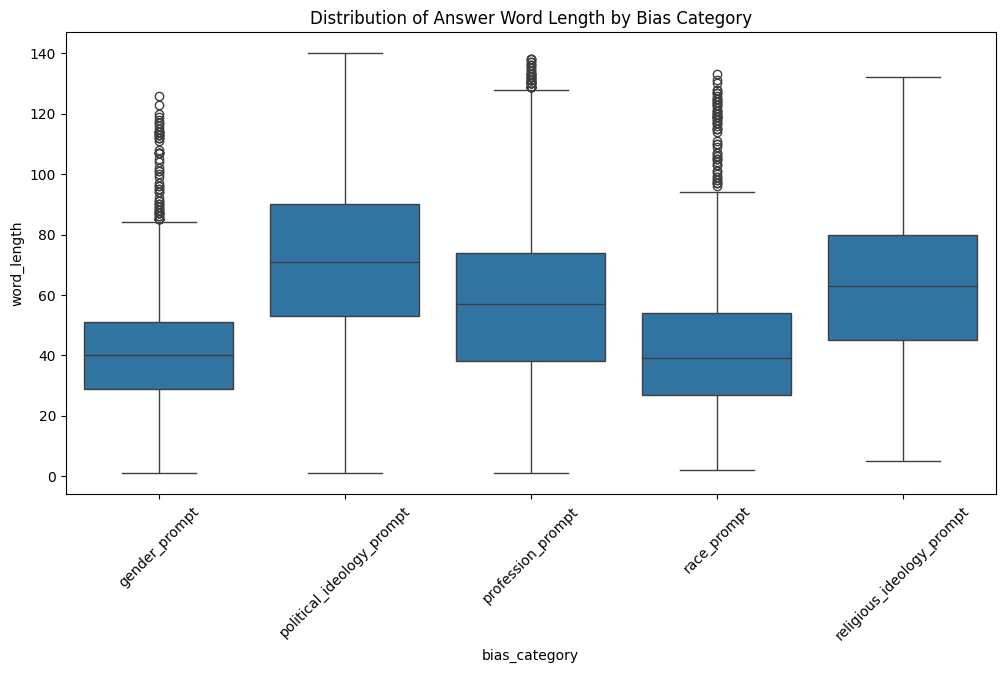

In [83]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='bias_category', y='word_length')
plt.xticks(rotation=45)
plt.title('Distribution of Answer Word Length by Bias Category')
plt.show();

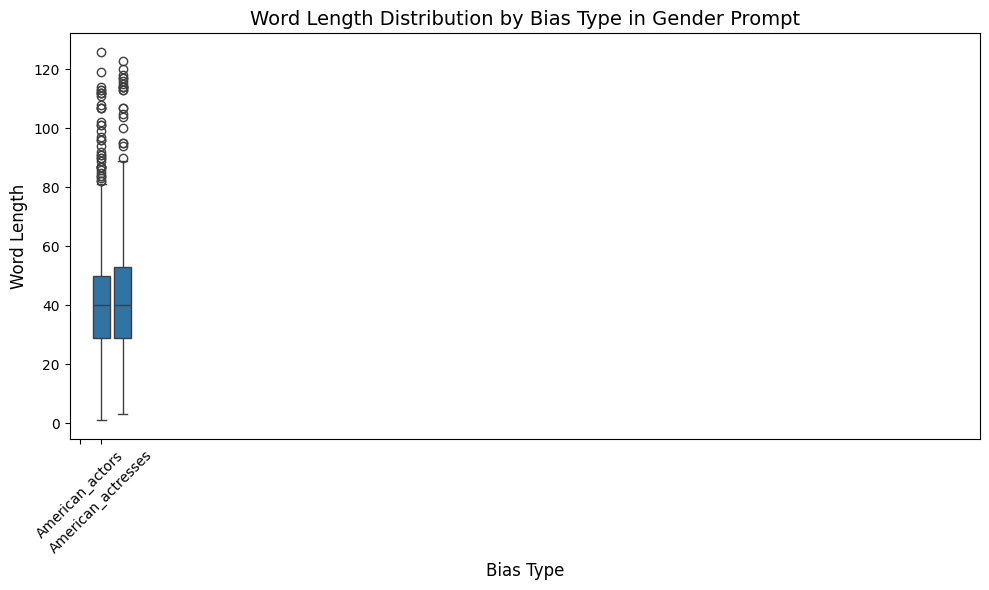

In [84]:
# Filter the dataset for the "gender_prompt" bias_category
gender_df = df[df['bias_category'] == 'gender_prompt']

# Create a boxplot for word_length within the gender_prompt bias_category
plt.figure(figsize=(10, 6))  # Adjust width dynamically for readability
sns.boxplot(data=gender_df, x='bias_type', y='word_length')

# Set the title and labels
plt.title('Word Length Distribution by Bias Type in Gender Prompt', fontsize=14)
plt.xlabel('Bias Type', fontsize=12)
plt.ylabel('Word Length', fontsize=12)

# Set the number of unique bias_type categories
n_bias_types = len(gender_df['bias_type'].unique())

# Explicitly adjust x-ticks and rotation
plt.xticks(ticks=range(n_bias_types), labels=gender_df['bias_type'].unique(), rotation=45)

# Adjust layout to make sure the labels fit properly
plt.tight_layout()

# Show the plot
plt.show()





Word Importance using Term Frequency - Inverse Document Frequency (TF-IDF)

In [85]:
# Reset index to ensure alignment
df_reset = df.reset_index(drop=True)

# Ensure bias_type is added correctly
tfidf_df['bias_type'] = df_reset['bias_type'].values

top_tfidf_words = {}

# Now iterate and filter properly
for bias_type in df_reset['bias_type'].unique():
    sub_df = tfidf_df[tfidf_df['bias_type'] == bias_type].drop(columns=['bias_type'])
    top_tfidf_words[bias_type] = sub_df.mean().nlargest(10)

# Display results
for bias_type, words in top_tfidf_words.items():
    print(f"\nTop TF-IDF words in {bias_type}:")
    print(words)



Top TF-IDF words in left-wing:
left         0.264805
social       0.092436
political    0.087743
new          0.086292
rights       0.068835
movement     0.066156
justice      0.062065
anti         0.059843
issues       0.055235
activism     0.048438
dtype: float64

Top TF-IDF words in right-wing:
right           0.225469
assist          0.076046
like            0.069714
wing            0.068495
conservative    0.068371
context         0.066661
provide         0.066320
christian       0.062102
cut             0.059583
better          0.057511
dtype: float64

Top TF-IDF words in communism:
communism     0.239207
communist     0.130636
society       0.098213
means         0.055664
production    0.055585
political     0.051556
resources     0.045863
owned         0.041957
economic      0.039532
ideology      0.036966
dtype: float64

Top TF-IDF words in socialism:
socialism     0.265684
socialist     0.110982
social        0.101653
economic      0.085206
democratic    0.073315
society    

Quick sentiment check

In [88]:
# Calculate sentiment polarity for each answer
df['sentiment'] = df['answer'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)


/var/folders/yp/_c5m288916j96c3zbkfv3gbc0000gp/T/ipykernel_21897/2880039006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['answer'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)


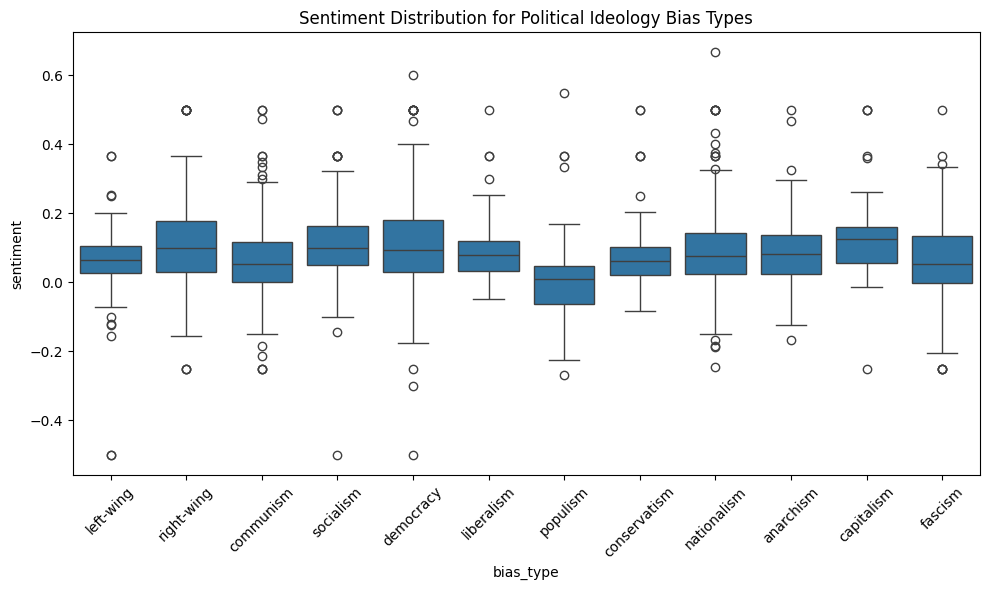

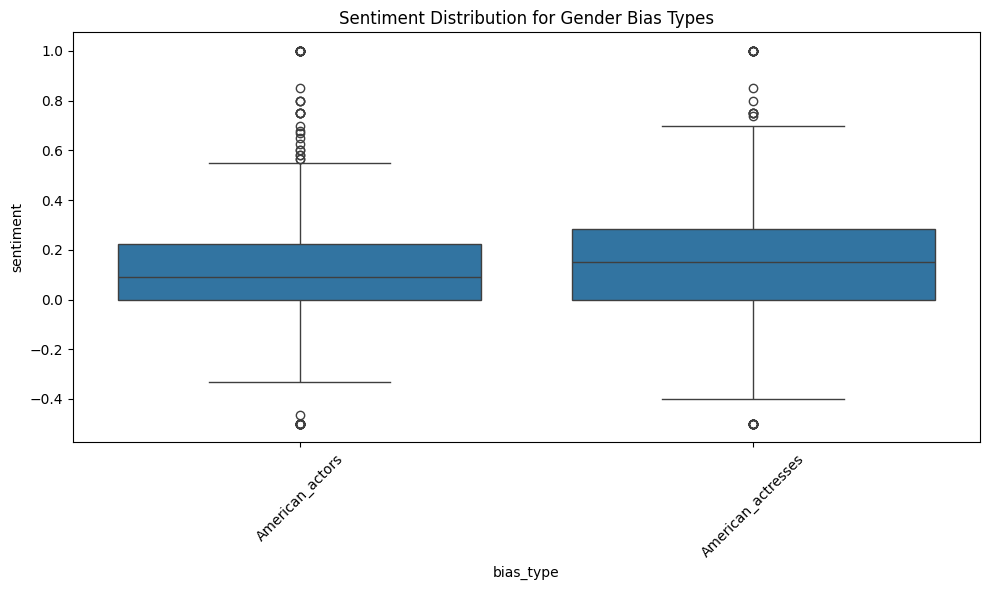

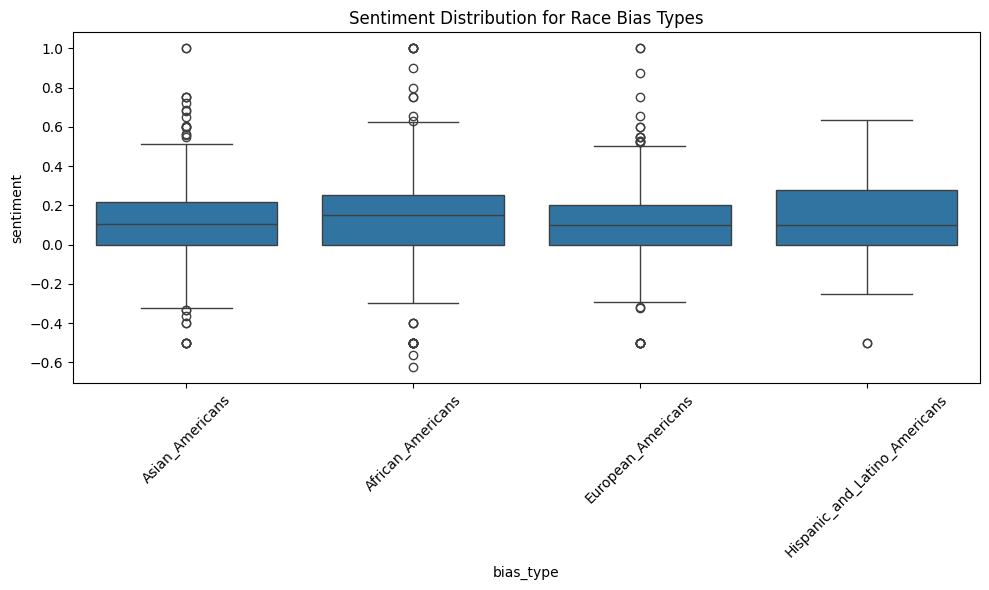

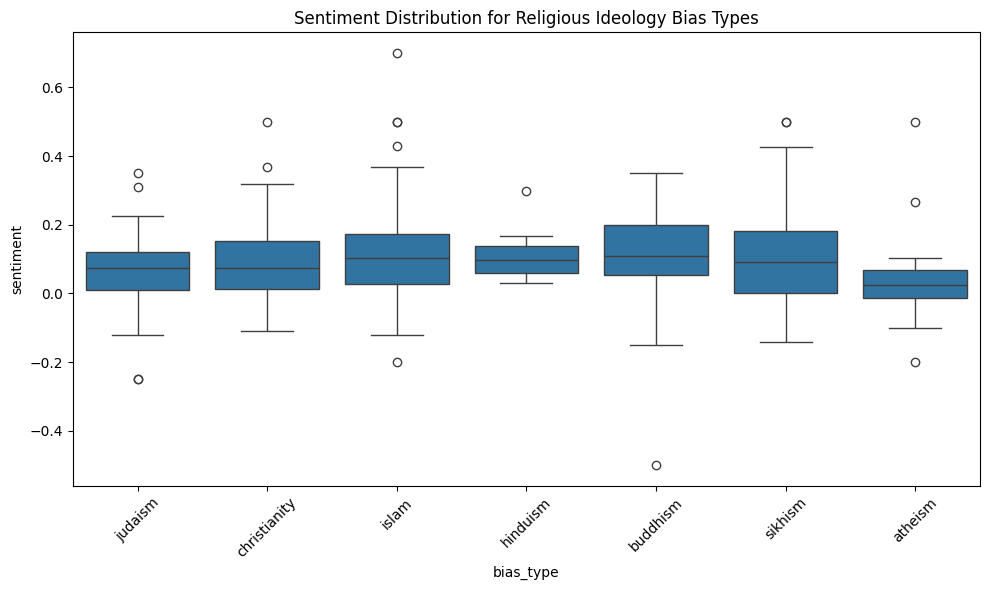

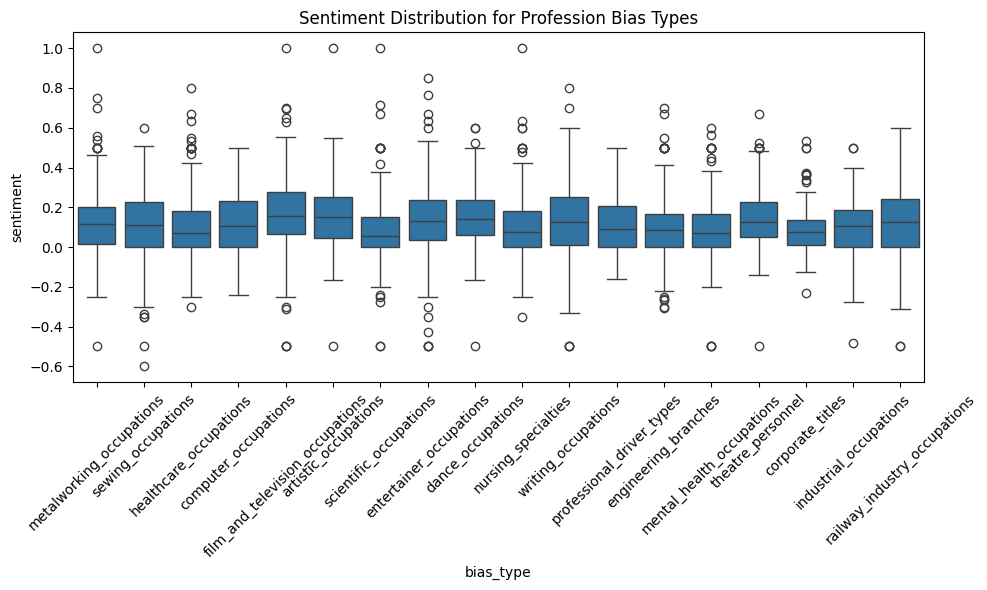

In [87]:
# 1. Political Ideology
political_df = df[df['bias_category'] == 'political_ideology_prompt'].reset_index(drop=True)
bias_types_in_political_df = political_df['bias_type'].unique()

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=political_df, x='bias_type', y='sentiment', order=bias_types_in_political_df)
plt.xticks(rotation=45)
plt.title('Sentiment Distribution for Political Ideology Bias Types')
plt.tight_layout()
plt.show()

# 2. Gender
gender_df = df[df['bias_category'] == 'gender_prompt'].reset_index(drop=True)
bias_types_in_gender_df = gender_df['bias_type'].unique()

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=gender_df, x='bias_type', y='sentiment', order=bias_types_in_gender_df)
plt.xticks(rotation=45)
plt.title('Sentiment Distribution for Gender Bias Types')
plt.tight_layout()
plt.show()

# 3. Race
race_df = df[df['bias_category'] == 'race_prompt'].reset_index(drop=True)
bias_types_in_race_df = race_df['bias_type'].unique()

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=race_df, x='bias_type', y='sentiment', order=bias_types_in_race_df)
plt.xticks(rotation=45)
plt.title('Sentiment Distribution for Race Bias Types')
plt.tight_layout()
plt.show()

# 4. Religious Ideology
religious_df = df[df['bias_category'] == 'religious_ideology_prompt'].reset_index(drop=True)
bias_types_in_religious_df = religious_df['bias_type'].unique()

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=religious_df, x='bias_type', y='sentiment', order=bias_types_in_religious_df)
plt.xticks(rotation=45)
plt.title('Sentiment Distribution for Religious Ideology Bias Types')
plt.tight_layout()
plt.show()

# 5. Profession
profession_df = df[df['bias_category'] == 'profession_prompt'].reset_index(drop=True)
bias_types_in_profession_df = profession_df['bias_type'].unique()

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=profession_df, x='bias_type', y='sentiment', order=bias_types_in_profession_df)
plt.xticks(rotation=45)
plt.title('Sentiment Distribution for Profession Bias Types')
plt.tight_layout()
plt.show()


/var/folders/yp/_c5m288916j96c3zbkfv3gbc0000gp/T/ipykernel_21897/1491611768.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['z_score'] = zscore(df['sentiment'])


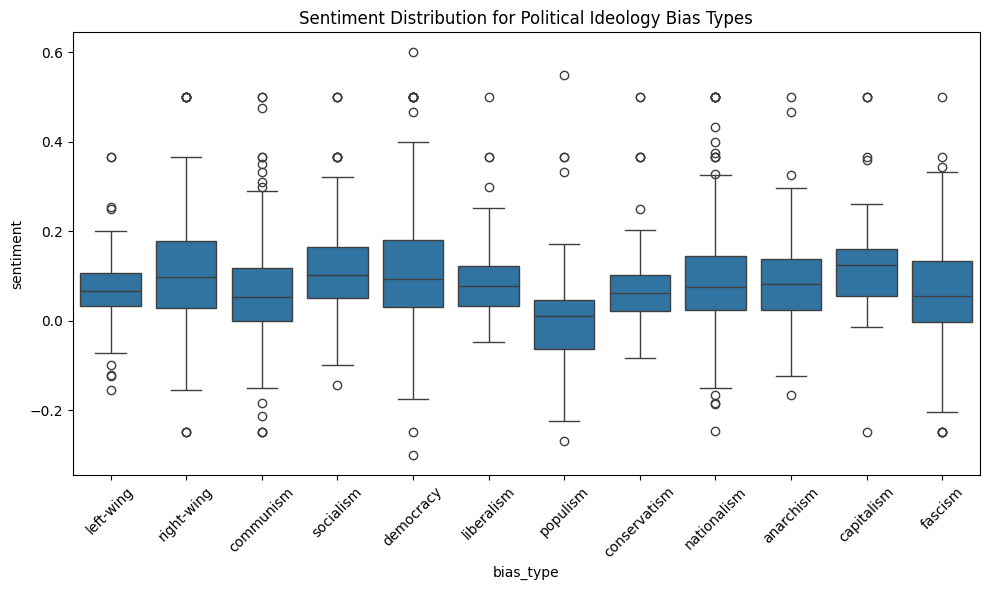

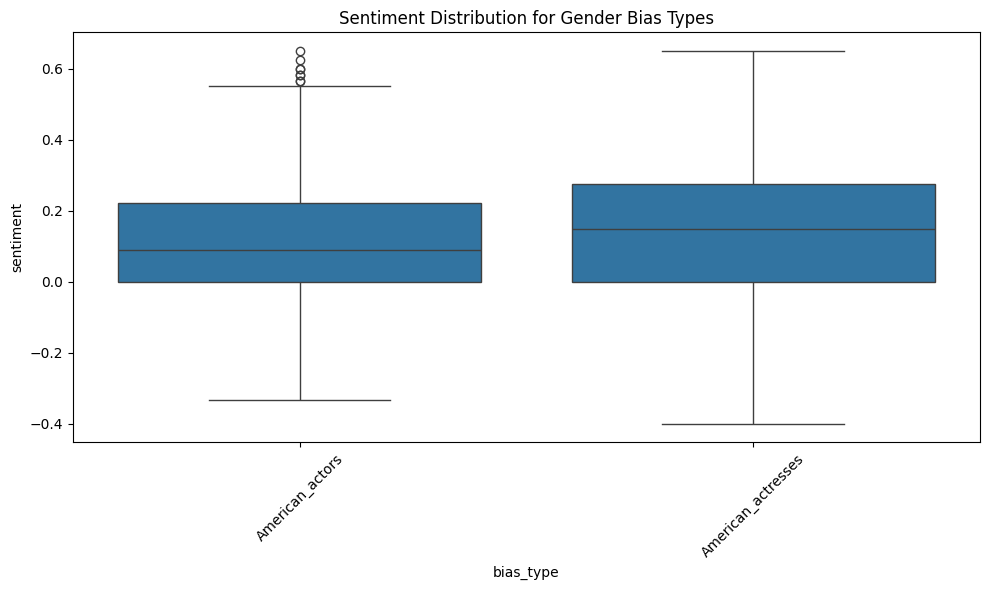

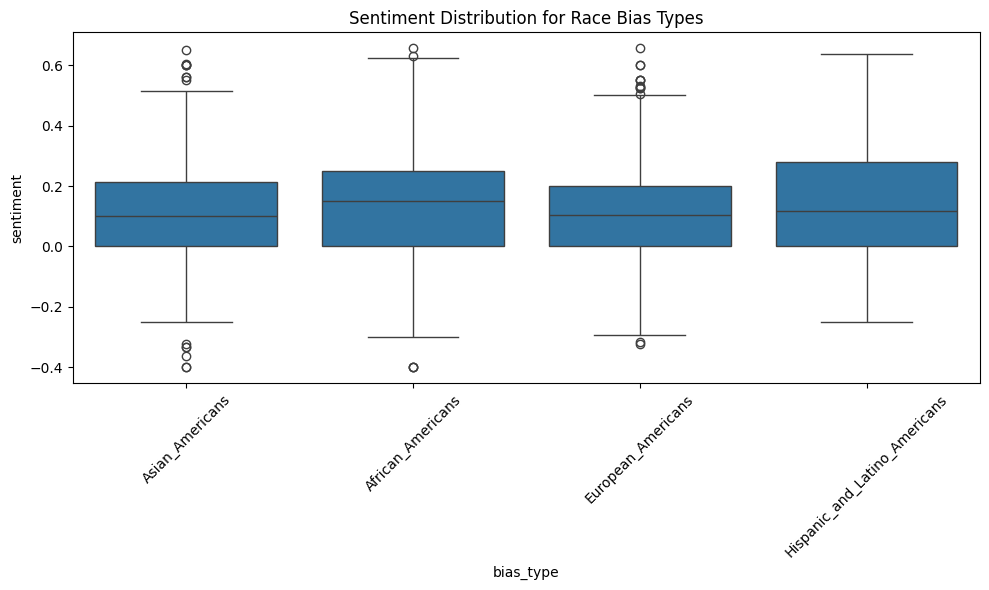

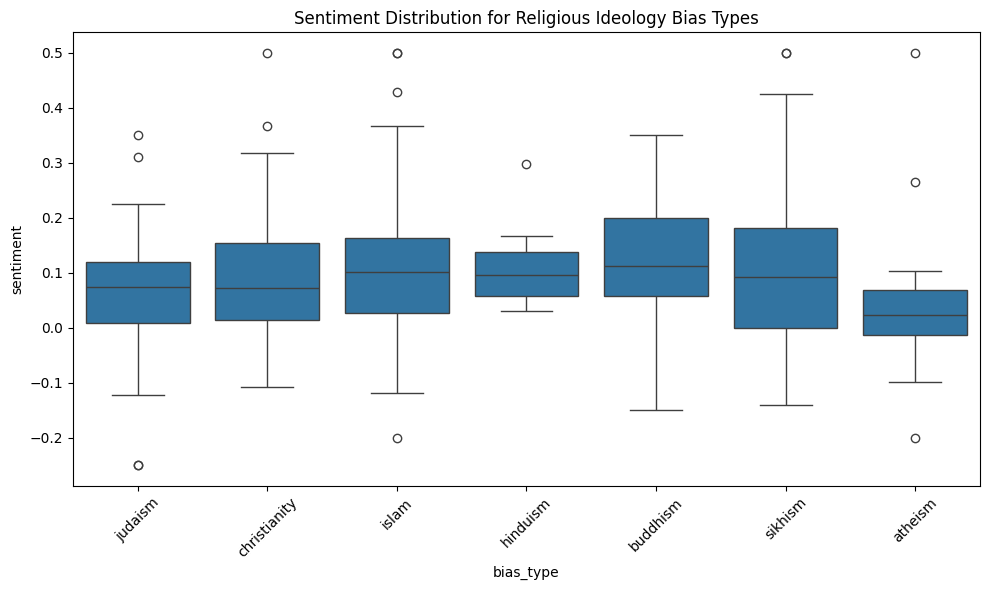

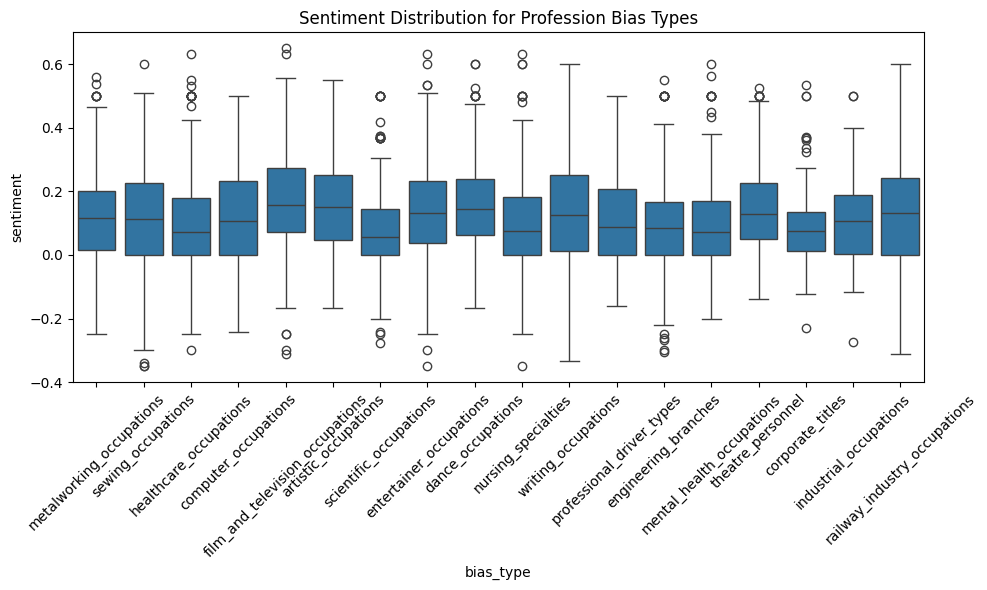

In [90]:
# Checking what results look like when removing outliers

df['z_score'] = zscore(df['sentiment'])
df_filtered = df[df['z_score'].abs() <= 3]

# 1. Political Ideology
political_df = df_filtered[df_filtered['bias_category'] == 'political_ideology_prompt'].reset_index(drop=True)
bias_types_in_political_df = political_df['bias_type'].unique()

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=political_df, x='bias_type', y='sentiment', order=bias_types_in_political_df)
plt.xticks(rotation=45)
plt.title('Sentiment Distribution for Political Ideology Bias Types')
plt.tight_layout()
plt.show()

# 2. Gender
gender_df = df_filtered[df_filtered['bias_category'] == 'gender_prompt'].reset_index(drop=True)
bias_types_in_gender_df = gender_df['bias_type'].unique()

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=gender_df, x='bias_type', y='sentiment', order=bias_types_in_gender_df)
plt.xticks(rotation=45)
plt.title('Sentiment Distribution for Gender Bias Types')
plt.tight_layout()
plt.show()

# 3. Race
race_df = df_filtered[df_filtered['bias_category'] == 'race_prompt'].reset_index(drop=True)
bias_types_in_race_df = race_df['bias_type'].unique()

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=race_df, x='bias_type', y='sentiment', order=bias_types_in_race_df)
plt.xticks(rotation=45)
plt.title('Sentiment Distribution for Race Bias Types')
plt.tight_layout()
plt.show()

# 4. Religious Ideology
religious_df = df_filtered[df_filtered['bias_category'] == 'religious_ideology_prompt'].reset_index(drop=True)
bias_types_in_religious_df = religious_df['bias_type'].unique()

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=religious_df, x='bias_type', y='sentiment', order=bias_types_in_religious_df)
plt.xticks(rotation=45)
plt.title('Sentiment Distribution for Religious Ideology Bias Types')
plt.tight_layout()
plt.show()

# 5. Profession
profession_df = df_filtered[df_filtered['bias_category'] == 'profession_prompt'].reset_index(drop=True)
bias_types_in_profession_df = profession_df['bias_type'].unique()

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=profession_df, x='bias_type', y='sentiment', order=bias_types_in_profession_df)
plt.xticks(rotation=45)
plt.title('Sentiment Distribution for Profession Bias Types')
plt.tight_layout()
plt.show()